# Achieved 98.9% Score on Test Data After Submission

## Import Libraries

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

2025-07-19 15:22:21.445441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752938541.666719      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752938541.727173      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Unzip Data

In [2]:
zip_path = '/kaggle/input/aerial-cactus-identification/train.zip'

extract_path = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
zip_path = '/kaggle/input/aerial-cactus-identification/test.zip'

extract_path = '/kaggle/working/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## Load Image Paths

In [4]:
train_images = glob.glob('/kaggle/working/train/*.jpg')
test_images = glob.glob('/kaggle/working/test/*.jpg')

In [5]:
print(train_images[0])
print(test_images[0])

/kaggle/working/train/47d6db767f477a884dab5d4effc4850f.jpg
/kaggle/working/test/97e0a5d563602682d0648809224cc26c.jpg


## Read Images & Labels

In [6]:
df = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')

In [7]:
df['image_path'] = '/kaggle/working/train/' + df['id']

In [8]:
df.head()

,id,has_cactus,image_path
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,/kaggle/working/train/0004be2cfeaba1c0361d39e2...
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,/kaggle/working/train/000c8a36845c0208e833c79c...
2,000d1e9a533f62e55c289303b072733d.jpg,1,/kaggle/working/train/000d1e9a533f62e55c289303...
3,0011485b40695e9138e92d0b3fb55128.jpg,1,/kaggle/working/train/0011485b40695e9138e92d0b...
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,/kaggle/working/train/0014d7a11e90b62848904c14...


In [9]:
images = []
labels = []

for i, row in df.iterrows():
    img = load_img(row['image_path'])
    img_array = img_to_array(img)
    
    images.append(img_array)
    labels.append(row['has_cactus'])

In [10]:
X_train = np.array(images)
y_train = np.array(labels)

In [11]:
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')

X_train Shape: (17500, 32, 32, 3)
y_train Shape: (17500,)


In [12]:
X_test = []
for path in test_images:
    img = load_img(path)  
    img_array = img_to_array(img)
    X_test.append(img_array)

X_test = np.array(X_test)

In [13]:
print(f'X_test Shape: {X_test.shape}')

X_test Shape: (4000, 32, 32, 3)


## Data Visualization

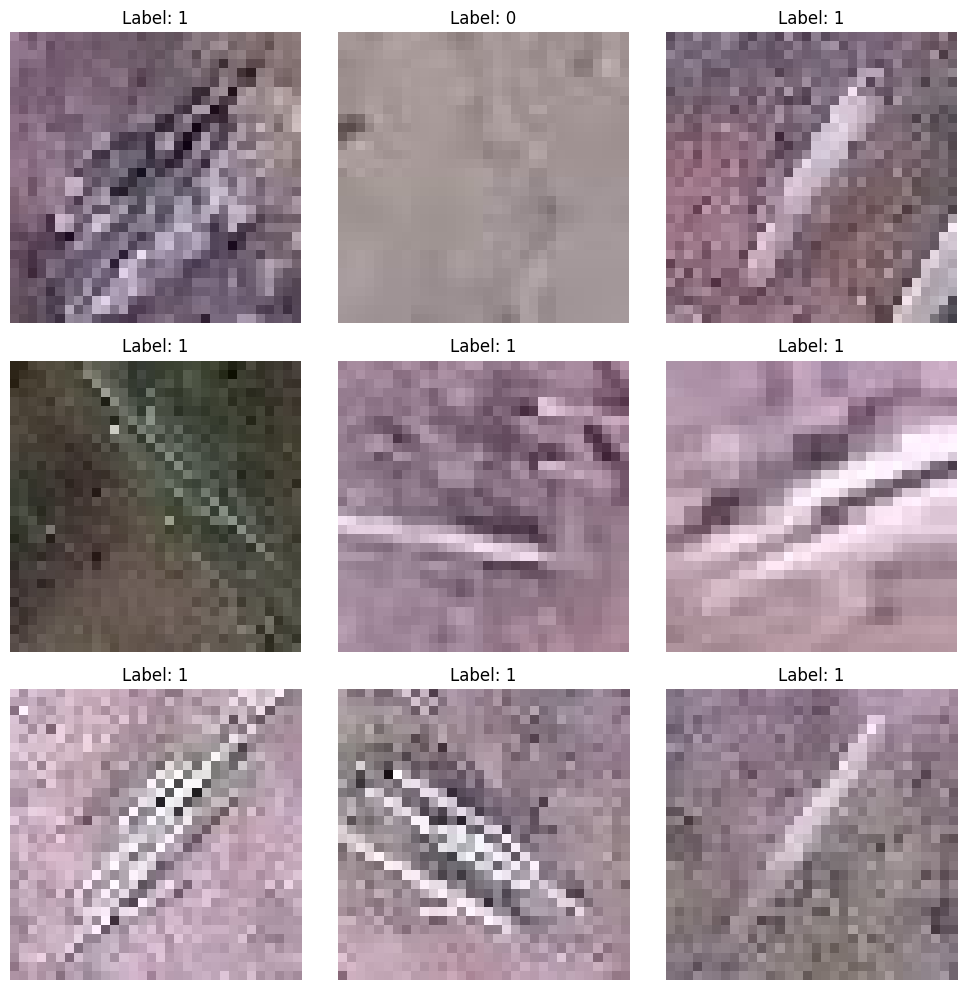

In [14]:
num_images = 9
plt.figure(figsize=(10, 10))
for i in range(num_images):
    idx = np.random.randint(0, X_train.shape[0])
    img = X_train[idx]
    label = y_train[idx]

    plt.subplot(3, 3, i + 1)
    plt.imshow(img.astype('uint8'))  
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

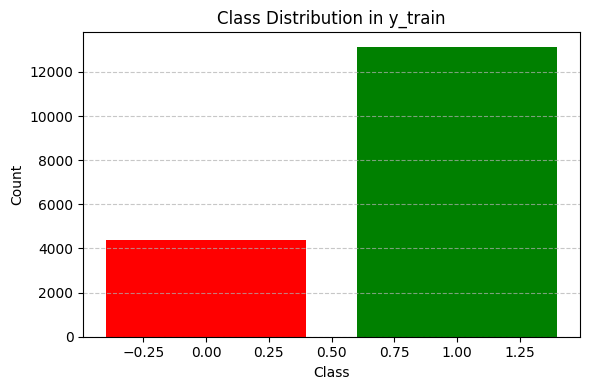

In [15]:
unique, counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color=['red', 'green'])
plt.title('Class Distribution in y_train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Buliding & Training Model

In [17]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),    
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(64, 'relu'),
    BatchNormalization(),
    Dense(32, 'relu'),
    Dense(1, 'sigmoid')
])
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1752938563.530206      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752938563.530833      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,761 (1.43 MB)

 Trainable params: 373,249 (1.42 MB)

 Non-trainable params: 512 (2.00 KB)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 2.0091848450057403, 1: 0.6656523392925067}


In [21]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/30


I0000 00:00:1752938569.112981     106 service.cc:148] XLA service 0x7bde08012a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752938569.113517     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752938569.113536     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752938569.552486     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 45/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.3077

I0000 00:00:1752938572.420641     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9197 - loss: 0.1893 - val_accuracy: 0.8894 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9697 - loss: 0.0813 - val_accuracy: 0.9223 - val_loss: 0.1841 - learning_rate: 0.0010
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9803 - loss: 0.0483 - val_accuracy: 0.9346 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9830 - loss: 0.0435 - val_accuracy: 0.8634 - val_loss: 0.4238 - learning_rate: 0.0010
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9875 - loss: 0.0294 - val_accuracy: 0.9291 - val_loss: 0.2022 - learning_rate: 0.0010
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9858 - loss: 0.0362 - val_accuracy: 0.9560 - val_loss: 0.1233 - learning_rate: 0.0010
Epoch 7/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9918 - loss: 0.0245 - val_accur

## Save & Submit Prediction

In [25]:
y_pred_probs = model.predict(X_val)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()
print(classification_report(y_val, y_pred_labels, digits=4))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0     0.9898    0.9932    0.9915       880
           1     0.9977    0.9966    0.9971      2620

    accuracy                         0.9957      3500
   macro avg     0.9938    0.9949    0.9943      3500
weighted avg     0.9957    0.9957    0.9957      3500



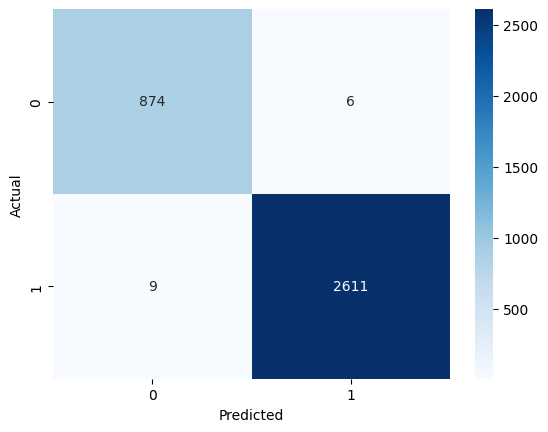

In [26]:
conf_matrix = confusion_matrix(y_val, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
df_test = pd.DataFrame({
    'id': [os.path.splitext(os.path.basename(p))[0] for p in test_images],
    'has_cactus': y_pred_labels
})

In [29]:
df_test['id'] = df_test['id'] + '.jpg'

In [30]:
df_test

,id,has_cactus
0,97e0a5d563602682d0648809224cc26c.jpg,1
1,c80a08a2daec8e14fba1bbe1e61ed357.jpg,0
2,331d209bbd4dbd97c5a7539ba7e2ad34.jpg,0
3,348a5e2625f40aed338b824b8b760f91.jpg,1
4,200eb447c7ac7267733b8d65b4a57e53.jpg,1
...,...,...
3995,4a76a997e7245c6302a8bec4dc6071a9.jpg,1
3996,76ad73729792e8aca8c62467fc6abea6.jpg,0
3997,bd25635cb1e68a155ba48fd2db9039a3.jpg,1
3998,849efb7717e9560ffea906ee7bfbd973.jpg,0


In [31]:
df_test.to_csv('submission.csv', index=False)